# Introduction

Author : Charles Le Losq.

This notebook tests the relationship between problem complexity, size of neural networks, size of the training set and interpolation/extrapolation abilities.

First we import all needed libraries.

In [1]:
# Library loading
%matplotlib inline

import pandas as pd # manipulate dataframes
import matplotlib.pyplot as plt # plotting
import matplotlib
import numpy as np
import rampy as rp

from sklearn import preprocessing # standardization
from sklearn.model_selection import train_test_split # to train/test split
from sklearn.ensemble import BaggingRegressor
from sklearn.gaussian_process import GaussianProcessRegressor as GPR
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.kernel_ridge import KernelRidge
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from sklearn.linear_model import LassoCV,MultiTaskLassoCV, MultiTaskElasticNet
from sklearn.metrics import mean_squared_error

from scipy.optimize import curve_fit

# fixing random seed
np.random.seed(42)

We define a function to explore, preferentially a strongly non-linear one.

In [2]:
def f2(x):
    return 0.1*x + 800*np.cos(x/15) - 1/60*x**2

Now I generate sparse data with this function, with a bit of noise.

Text(0, 0.5, 'Y')

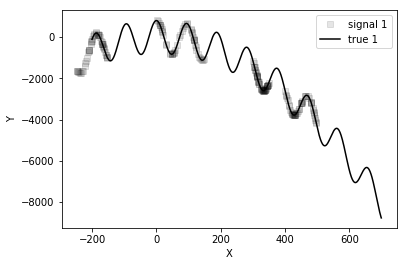

In [3]:
a = 1.
b = 150.

x0 = (-150 - -50) * np.random.random_sample(50) + -150
x = (b - a) * np.random.random_sample(50) + a
xp = (500.0 - 400.0) * np.random.random_sample(50) + 400.0
xp2 = (350.0 - 300.0) * np.random.random_sample(50) + 300.0

x = np.sort(np.concatenate((x0,x,xp,xp2)))

y = f2(x)

noise = 20*np.random.randn(len(x))

y_noisy = y+noise

X_interp = np.arange(-200,700)

plt.plot(x,y_noisy,"ks",alpha=0.1,label="signal 1")
plt.plot(X_interp,f2(X_interp),"k-",label="true 1")
plt.legend()
plt.xlabel("X")
plt.ylabel("Y")

In the following we use the mlregressor class of the rampy library for convenience, which is a high-level API to the scikit-learn algorithms.

I will post in the future a low-level version using Flux.jl in the Julia language to compare performance.

The first model is a one-layer network with 100 units and tanh activation functions. Problem is solved with the lbfgs solver. This will be an "historical" neural net.

In [4]:
model1 =rp.mlregressor(x.reshape(-1, 1),y_noisy.reshape(-1, 1))
model1.scaler = 'StandardScaler'
model1.param_neurons['hidden_layer_sizes'] = (100,) 
model1.param_neurons['activation'] = "tanh"
model1.algorithm = "NeuralNet"
model1.param_neurons['solver'] = "lbfgs"
model1.param_bagging = dict(n_estimators=100, max_samples=100, max_features=len(x), bootstrap=True, bootstrap_features=False, oob_score=False, warm_start=False, n_jobs=2, verbose=0)
model1.fit()

The second network is a deep one, 5 layers of 100 neurons, with relu activation function. We still use lbfgs for optimization as the dataset is (on purpose) small.

In [5]:
model2_deep =rp.mlregressor(x.reshape(-1, 1),y_noisy.reshape(-1, 1))
model2_deep.scaler = 'StandardScaler'
model2_deep.algorithm = 'NeuralNet'
model2_deep.param_neurons['hidden_layer_sizes'] = (100,100,100,100,100) 
model2_deep.param_neurons['activation'] = "relu"
model2_deep.param_neurons['solver'] = "lbfgs"
model2_deep.param_neurons['max_iter']=10000
model2_deep.fit()

And the first model is a simple kernel ridge regression algorithm. Rampy performs automatic hyperparameter tuning, so we don't need to do too much there.

In [6]:
model3_krr =rp.mlregressor(x.reshape(-1, 1),y_noisy.reshape(-1, 1))
model3_krr.scaler = 'StandardScaler'
model3_krr.algorithm = 'KernelRidge'
model3_krr.fit()

And we plot the result for final comparison. Which one is the best????

ValueError: non-broadcastable output operand with shape (1400,1) doesn't match the broadcast shape (1400,3)

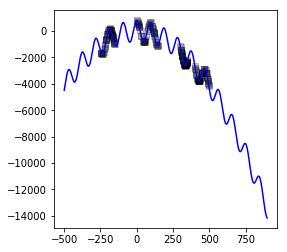

In [12]:
X_interp = np.arange(-500,900)

plt.figure(figsize=(4,4))

plt.plot(x,y+noise,"ks",alpha=0.2,label="signal 1")

plt.plot(X_interp,f2(X_interp),"b-",label="true 1")

plt.plot(X_interp,model1.predict(X_interp.reshape(-1,1)),"--",color="purple",label="SNN")
plt.plot(X_interp,model3_krr.predict(X_interp.reshape(-1,1)),"--",color="cyan",label="KRR")
plt.plot(X_interp,model2_deep.predict(X_interp.reshape(-1,1)),"r--",label="DNN")

plt.xlabel("X")
plt.ylabel("Y")

#plt.ylim(-500,300)

plt.legend()

From what we can see above, it seems the deep network performs fairly well, as well as the kernel ridge regression algorithm. The shallow network with not-too-much neurons captures the general trend but not the 2nd order variations...

Let's now compare all models on a problem even more non-linear with three X inputs.

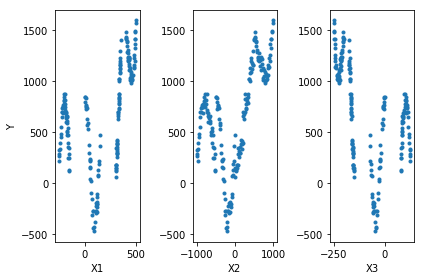

In [8]:
def f1(x):
    return 2.0 *x[:,0] + 0.001* x[:,1]**2 + 600*np.cos(x[:,2]/15.0)

x_array = np.vstack((x,np.linspace(-1000,1000,len(x)),-x/2)).T

y2 = f1(x_array) 
noise2 = 50*np.random.randn(len(y2))

y2_noisy = y2+noise2

plt.figure()

plt.subplot(1,3,1)
plt.plot(x_array[:,0],y2_noisy,'.')
plt.xlabel('X1')
plt.ylabel('Y')
plt.subplot(1,3,2)
plt.plot(x_array[:,1],y2_noisy,'.')
plt.xlabel('X2')
plt.subplot(1,3,3)
plt.plot(x_array[:,2],y2_noisy,'.')
plt.xlabel('X3')

plt.tight_layout()

In [9]:
model1 =rp.mlregressor(x_array,y2_noisy.reshape(-1, 1))
model1.scaler = 'StandardScaler'
model1.param_neurons['hidden_layer_sizes'] = (100,) 
model1.param_neurons['activation'] = "tanh"
model1.algorithm = "NeuralNet"
model1.param_neurons['solver'] = "lbfgs"
model1.param_neurons['max_iter']=10000
model1.fit()

model2_deep =rp.mlregressor(x_array,y2_noisy.reshape(-1, 1))
model2_deep.scaler = 'StandardScaler'
model2_deep.algorithm = 'NeuralNet'
model2_deep.param_neurons['hidden_layer_sizes'] = (100,100,100,100,100) 
model2_deep.param_neurons['activation'] = "relu"
model2_deep.param_neurons['solver'] = "lbfgs"
model2_deep.param_neurons['max_iter']=10000
model2_deep.fit()

model3_krr =rp.mlregressor(x_array,y2_noisy.reshape(-1, 1))
model3_krr.scaler = 'StandardScaler'
model3_krr.algorithm = 'KernelRidge'
model3_krr.fit()

We now plot the comparison between measured and predicted values.

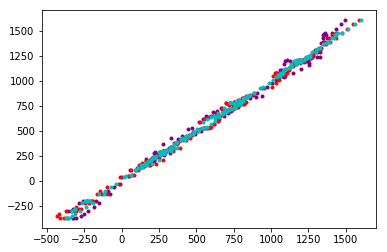

In [10]:
plt.plot(model1.predict(x_array),y2,".",color="purple",label="shallow")
plt.plot(model2_deep.predict(x_array),y2,"r.",label="DNN")
plt.plot(model3_krr.predict(x_array),y2,"c.",label="KRR")


In [11]:
print(mean_squared_error(model1.predict(x_array),y2))
print(mean_squared_error(model2_deep.predict(x_array),y2))
print(mean_squared_error(model3_krr.predict(x_array),y2))

1997.0625932744122
857.2669491154477
366.7358952065186


Interesting. Best results are obtained using the kernel ridge regression algorithm, followed by the deep network, and then the shallow one. So the conclusion: don't be afraid to train deep networks, even for simple problems! And try kernel ridge regression...